In [1]:
from pydantic import BaseModel, Field, ValidationError, validator
from typing import List, Tuple
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

#setting max row to 300
pd.set_option('display.max_rows',300)

In [98]:
class MontecarloOptionPricing(BaseModel):
    
    
    S0: float = Field(..., gt=0, description="Initial stock price")
    K: float = Field(..., gt=0, alias = "strike", description="Strike price")
    r: float = Field(..., ge=0, le=1, alias="rate", description="Risk-free rate")
    sigma: float = Field(..., gt=0, le=1, description="Volatility")
    T: int = Field(..., gt=0, lt=3650, alias="dte", description="Time to expiry")
    N: int = Field(..., gt=0, alias="nsim", description="number of simulations")
    ts: int = Field(252, gt=0, alias = "timesteps", description="Number of timesteps" )
        
    class Config:
        allow_population_by_field_name = True
        
        
    #Alternate way to validate
    @validator('T')
    def check_T(cls, v):
        if v>365*10: #assuming max of 10 years
            raise ValueError('Days to expiration should not exceed 3650 (10 years)')
        return v
        
    @validator('N')
    def check_N(cls,v):
        if v>1_000_000: 
            raise ValueError('Number of simulations should not exceed 1,000,000')
        return v
    
    #calculating a discount factor
    @property
    def df(self) -> float:
        return np.exp(-self.r * self.T)
    
    @property
    def pseudorandomnumber(self) -> np.ndarray:
        return np.random.standard_normal(self.N)
    
    @property
    def simulatedpath(self) -> np.ndarray:
        
        np.random.seed(2024)
        
        dt = self.T/self.ts
        
        S = np.zeros((self.ts, self.N))
        S[0] = self.S0
        
        for i in range (0, self.ts-1):
            w = self.pseudorandomnumber
            S[i+1] = S[i] * (1 + self.r * dt + self.sigma * np.sqrt(dt) * w)
            
        return S
    
    @property
    def vanillaopspayoff(self) -> List[float]:
        """Calculate the vanilla option payoff"""
        S = self.simulatedpath
        
        vanilla_call_payoff = self.df * np.mean(np.maximum(0, S[-1] - self.K))
        vanilla_put_payoff = self.df * np.mean(np.maximum(0, self.K - S[-1]))
        
        return [vanilla_call_payoff, vanilla_put_payoff]
    
    @property
    def asianopspayoff(self) -> List[float]:
        """Asian option payoff"""
        S = S = self.simulatedpath
        
        A = S.mean(axis = 0)
        
        asian_call = self.df * np.mean(np.maximum(0, A - self.K))
        asian_put = self.df * np.mean(np.maximum(0, self.K - A))
        
        return [asian_call, asian_put]
    

    def upandoutcall(self, barrier: int = 150, rebate: int = 0) -> Tuple[float, float]:
        
        S = self.simulatedpath
        
        barriershift = barrier * np.exp(0.5826 * self.sigma * np.sqrt(self.T/self.ts))
        
        value = 0
        for i in range(self.N):
            if S[:, i].max() > barriershift:
                value += np.maximum(0, S[-1, i] - self.K )
            else:
                value += rebate
                
        return (self.df*value/self.N, barriershift)
            
    
        
    
    

C:\Users\Darshan\AppData\Local\Temp\ipykernel_15136\2283652648.py:17: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  @validator('T')
C:\Users\Darshan\AppData\Local\Temp\ipykernel_15136\2283652648.py:23: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.8/migration/
  @validator('N')
C:\Users\Darshan\.anaconda\Lib\site-packages\pydantic\_internal\_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has 

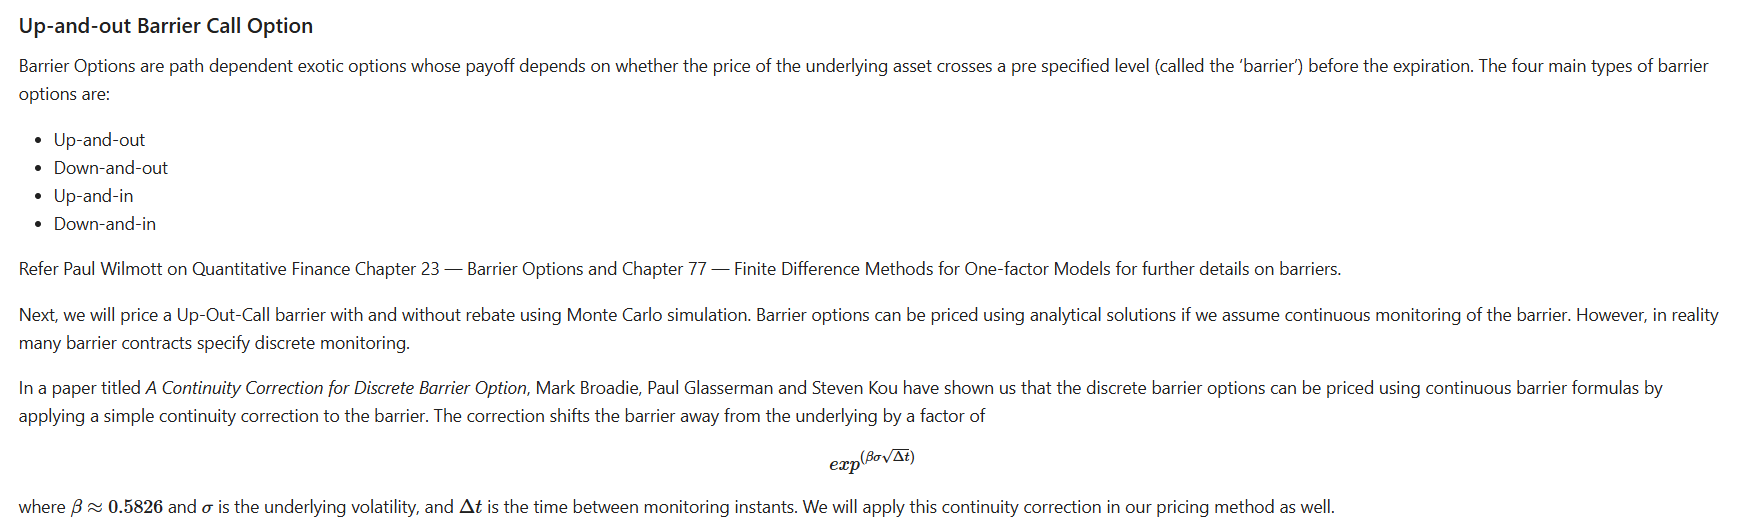

In [99]:
#Now let's try and calculate the price

try:
    option1 = MontecarloOptionPricing(
            S0=100,
            strike=100,
            rate=0.05,
            sigma=0.2,
            dte=1,
            nsim=100000,
            timesteps=252
        )
except ValidationError as e:
    print(f"\nValidation error: {e}")

In [100]:
pd.DataFrame(option1.simulatedpath).head(2)

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.00000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.00000,100.000000,100.000000
1,102.121383,100.948812,99.765928,99.82971,101.173958,101.481719,96.718999,98.350127,100.599372,100.148414,...,100.34369,101.838621,99.128963,100.129858,97.246274,99.60355,101.377545,99.49875,98.363364,99.097818


In [101]:
pd.DataFrame(option1.simulatedpath).tail(2)

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
250,141.437673,119.854615,90.473423,147.121107,124.461143,83.101166,111.542425,124.106212,116.674454,163.886254,...,105.746454,107.471261,115.694412,123.081588,113.559476,90.912640,70.243959,77.676287,112.050906,103.906380
251,142.982456,120.072472,90.316633,148.781911,122.771249,84.048953,113.849639,124.499340,117.936273,167.296821,...,106.739564,106.694851,115.834640,123.167677,112.881114,91.791613,70.620528,76.259556,112.470420,103.800921


### Histogram

(array([3.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 6.000e+00,
        6.000e+00, 1.000e+01, 1.200e+01, 1.800e+01, 1.700e+01, 2.100e+01,
        2.900e+01, 3.800e+01, 4.800e+01, 6.300e+01, 6.500e+01, 9.700e+01,
        1.130e+02, 1.410e+02, 1.680e+02, 2.270e+02, 2.150e+02, 3.240e+02,
        3.850e+02, 4.210e+02, 4.970e+02, 5.790e+02, 6.510e+02, 8.060e+02,
        8.600e+02, 9.750e+02, 1.071e+03, 1.296e+03, 1.441e+03, 1.582e+03,
        1.752e+03, 1.906e+03, 2.091e+03, 2.196e+03, 2.393e+03, 2.531e+03,
        2.725e+03, 2.834e+03, 2.948e+03, 3.103e+03, 3.082e+03, 3.063e+03,
        3.206e+03, 3.392e+03, 3.276e+03, 3.295e+03, 3.160e+03, 3.117e+03,
        3.067e+03, 3.000e+03, 2.822e+03, 2.807e+03, 2.516e+03, 2.384e+03,
        2.264e+03, 2.174e+03, 1.992e+03, 1.787e+03, 1.597e+03, 1.493e+03,
        1.366e+03, 1.202e+03, 1.048e+03, 9.020e+02, 7.800e+02, 7.130e+02,
        6.440e+02, 5.410e+02, 4.650e+02, 3.850e+02, 3.570e+02, 3.000e+02,
        2.330e+02, 1.630e+02, 1.420e+0

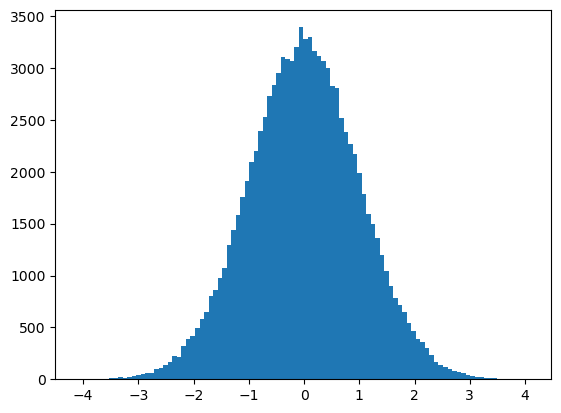

In [102]:
pseudorandomnumber = option1.pseudorandomnumber

plt.hist(pseudorandomnumber, bins=100)

### Histogram of simulated paths

(array([2.000e+00, 4.000e+00, 2.000e+01, 3.100e+01, 5.100e+01, 1.130e+02,
        1.580e+02, 2.570e+02, 3.710e+02, 4.970e+02, 6.880e+02, 8.920e+02,
        1.136e+03, 1.355e+03, 1.734e+03, 2.103e+03, 2.458e+03, 2.730e+03,
        3.031e+03, 3.269e+03, 3.566e+03, 3.886e+03, 3.900e+03, 4.136e+03,
        4.285e+03, 4.226e+03, 4.265e+03, 4.098e+03, 3.975e+03, 3.842e+03,
        3.602e+03, 3.407e+03, 3.217e+03, 3.033e+03, 2.828e+03, 2.547e+03,
        2.340e+03, 2.143e+03, 1.978e+03, 1.728e+03, 1.532e+03, 1.444e+03,
        1.231e+03, 1.079e+03, 1.008e+03, 8.560e+02, 7.380e+02, 6.230e+02,
        5.210e+02, 4.450e+02, 3.720e+02, 3.110e+02, 3.160e+02, 2.510e+02,
        2.260e+02, 1.720e+02, 1.430e+02, 1.340e+02, 1.260e+02, 1.110e+02,
        8.900e+01, 6.000e+01, 5.700e+01, 2.800e+01, 2.900e+01, 2.900e+01,
        2.700e+01, 1.500e+01, 2.700e+01, 2.000e+01, 1.300e+01, 1.100e+01,
        8.000e+00, 7.000e+00, 2.000e+00, 9.000e+00, 3.000e+00, 3.000e+00,
        4.000e+00, 5.000e+00, 1.000e+0

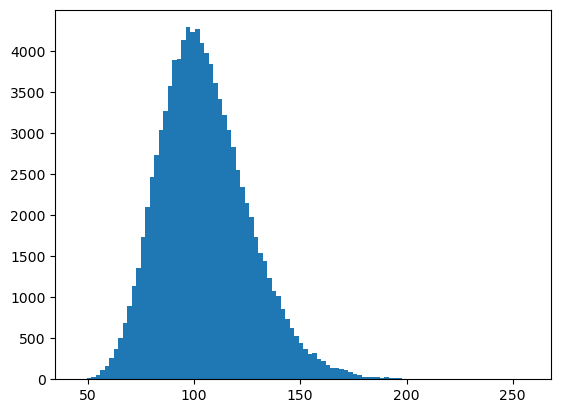

In [103]:
plt.hist(option1.simulatedpath[-1], bins = 100)

### VIsualisation of simulated paths

Text(0.5, 1.0, 'Monte carlo simulation')

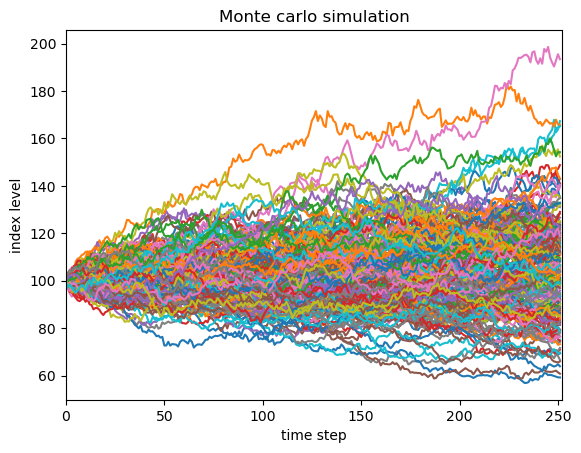

In [104]:
plt.plot(option1.simulatedpath[:, :200])
plt.xlabel('time step')
plt.xlim(0,252)
plt.ylabel('index level')
plt.title('Monte carlo simulation')

In [105]:
#European option
print(f"European call option price is {option1.vanillaopspayoff[0]:0.4f}")
print(f"European put option price is {option1.vanillaopspayoff[1]:0.4f}")

European call option price is 10.4352
European put option price is 5.5305


In [106]:
#Asian option
print(f"Asian call option price is {option1.asianopspayoff[0]:0.4f}")
print(f"Asian put option price is {option1.asianopspayoff[1]:0.4f}")

Asian call option price is 5.7251
Asian put option price is 3.3246


In [111]:
#barrier option price
print(f"Up-and-Out Barrier Call Option Value is {option1.upandoutcall()[0]:0.4f}")

Up-and-Out Barrier Call Option Value is 2.4161


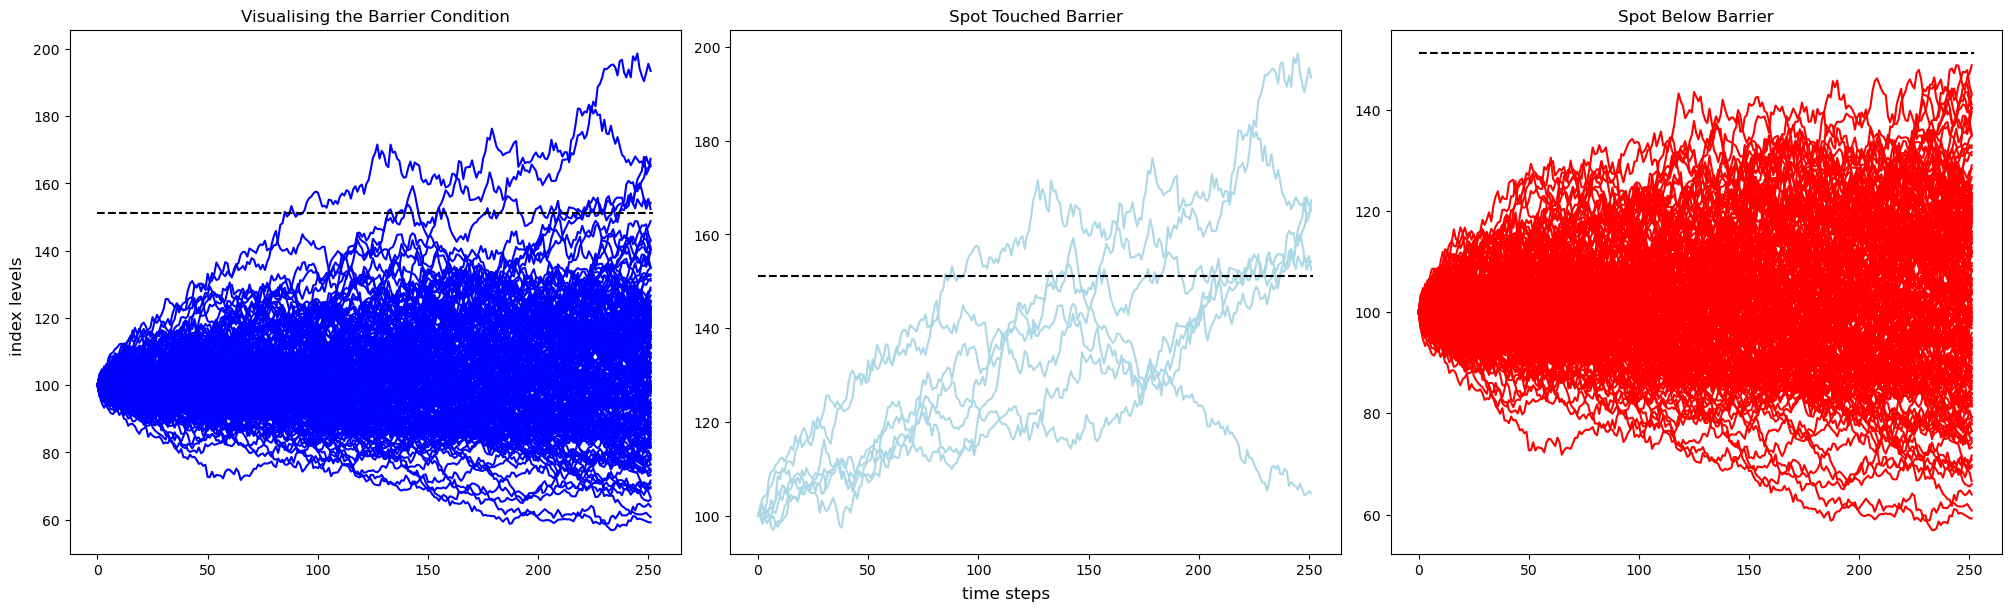

In [113]:
figure, axes = plt.subplots(1,3, figsize=(20,6), constrained_layout=True)
title = ['Visualising the Barrier Condition', 'Spot Touched Barrier', 'Spot Below Barrier']

# Get simulated path
S = option1.simulatedpath
B_shift = option1.upandoutcall()[1]

axes[0].plot(S[:,:200], color = 'blue')      
for i in range(200):
    axes[1].plot(S[:,i], color = 'lightblue') if S[:,i].max() > B_shift else axes[2].plot(S[:,i], color = 'red')

for i in range(3):
    axes[i].set_title(title[i])
    axes[i].hlines(B_shift, 0, 252, colors='k', linestyles='dashed')

figure.supxlabel('time steps')
figure.supylabel('index levels')

plt.show()